In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
! git clone https://github.com/metal3d/keras-video-generators.git

Cloning into 'keras-video-generators'...
remote: Enumerating objects: 614, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 614 (delta 47), reused 75 (delta 35), pack-reused 514
Receiving objects: 100% (614/614), 7.77 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (279/279), done.


In [3]:
# 다운로드한 폴더로 이동
import os
os.chdir("/content/keras-video-generators/")

In [4]:
# git 컴파일
! python setup.py build

/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'licence_file'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib
creating build/lib/keras_video
copying src/keras_video/__init__.py -> build/lib/keras_video
copying src/keras_video/generator.py -> build/lib/keras_video
copying src/keras_video/sliding.py -> build/lib/keras_video
copying src/keras_video/utils.py -> build/lib/keras_video
copying src/keras_video/flow.py -> build/lib/keras_video


In [5]:
# 폴더 생성
! mkdir /content/keras_video
# git 파일 복사 /content/keras_video
! cp /content/keras-video-generators/build/lib/keras_video/*.*  /content/keras_video

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import cv2
import pandas as pd
from tensorflow.keras.utils import to_categorical
from keras_video import VideoFrameGenerator

import sklearn
import keras_video.utils
from tensorflow_docs.vis import embed
import imageio
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
from sklearn.model_selection import train_test_split

from keras.applications import mobilenet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, GRU
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [9]:
data_path = '/content/drive/MyDrive'

In [10]:
X_train = np.load(data_path + '/data/X_train_wide(5).npy')

In [11]:
y_train = np.load(data_path + '/data/y_train_wide(5).npy')

In [12]:
X_train.shape

(356, 20, 224, 224, 3)

In [13]:
#입력값을 읽어서 예측을 할 Sequential 객체 생성
model = Sequential()

In [15]:
model.add(
    TimeDistributed(
        tf.keras.applications.mobilenet.MobileNet(
            weights='imagenet'
            ,include_top=False
            ,input_shape=(224,224,3)
        )
        ,input_shape=(20,224,224,3)
    )
)
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(256, dropout=0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(3, activation='softmax'))

17235968/17225924 [==============================] - 0s 0us/step


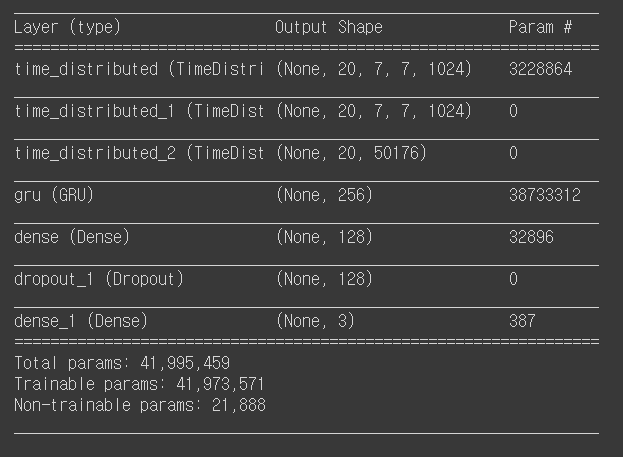

In [16]:
#생성된 모델 정보 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 7, 7, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 7, 7, 1024)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 50176)         0         
_________________________________________________________________
gru (GRU)                    (None, 256)               38733312  
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

# 교차검증용 데이터셋 분할

In [17]:
# train, validation data 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

# 비디오 제너레이터를 이용해 학습

In [18]:
print(X_train.shape)
print(y_train.shape)

(267, 20, 224, 224, 3)
(267, 3)


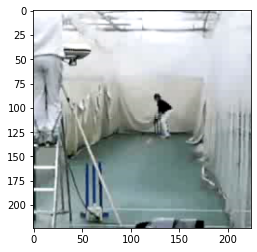

In [19]:
plt.imshow(X_train[0][0])

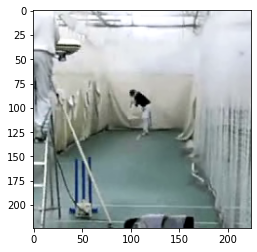

In [20]:
plt.imshow(X_train[0][19])

In [21]:
classes = ['CricketShot', 'Punch', 'TennisSwing']

In [22]:
classes

['CricketShot', 'Punch', 'TennisSwing']

In [23]:
# 이미지 사이즈
SIZE = (224, 224)
CHANNELS = 3

In [24]:
# 비디오 프레임의 이미지를 변형 할 객체 변형할 객체
train_image_data_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30, # 이미지 회전 각도 최대 30도
	zoom_range=0.15, # 이미지 확대 비율 
	width_shift_range=0.2, # 이미지 가로 이동 비율
	height_shift_range=0.2, # 이미지 세로 이동 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전을 가능하도록 설정
	fill_mode="nearest", # 이미지를 회전 이동시 빈공간을 채우는 방식
)

In [25]:
# 데이터 경로
data_path = "/content/drive/MyDrive/cloud_ai/16.모듈프로젝트04/workspace/"

In [26]:
# 비디오 파일의 클래스 v_다음이 클래스임
glob_pattern = data_path + 'train/v_{classname}_*.avi'

In [27]:
# 비디오 프레임 20개 생성할 객체
train_video_generator = VideoFrameGenerator(
    classes=classes, # 분류할 클래스 설정 : ['CricketShot', 'Punch', 'TennisSwing']
    glob_pattern=glob_pattern, # 파일명에서 클래스 정보를 따옴
    nb_frames=20,              # 시퀀스의 프레임의 수 
    split=.33,                 # 검증용 파일로 나눌 분할 비율 
    shuffle=True,              # 섞을 것 인지 
    batch_size=2,              # 배치사이즈는 2로 설정 한 배치의 시퀀스 수
    target_shape=SIZE,         # 요소 2에서 만든 (224,224)
    nb_channel=CHANNELS,       # 요소 2에서 만든 3  3이니까 RGB 채널 
    transformation=train_image_data_gen, # 요소 3에서 만든 비디오 프레임의 변형 
    use_frame_cache=True       # 프레임 캐시를 사용할지 여부 / 사용을 위해 다량의 메모리 필요 
    )

Total data: 3 classes for 356 files for train


In [28]:
glob_pattern

'/content/drive/MyDrive/cloud_ai/16.모듈프로젝트04/workspace/train/v_{classname}_*.avi'

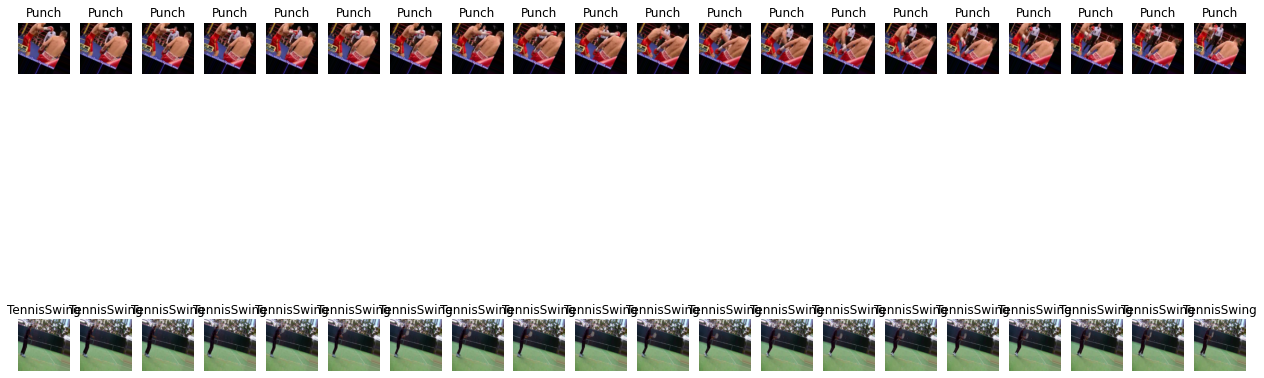

In [29]:
# 비디오 프레임 샘플 데이터 조회 (배치사이즈 만큼)
keras_video.utils.show_sample(train_video_generator)

In [30]:
model.compile(
                  loss="categorical_crossentropy", 
                   optimizer=Adam(lr=1e-4),
                   metrics=["acc"]
              )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# checkpoint 활용

In [31]:
# checkpoint 만들기
checkpoint_path = '/content/drive/MyDrive/check/tmp_checkpoint.ckpt'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path
    ,save_weights_only=True
    ,save_best_only=True
    ,monitor='val_loss'
    ,verbose=1
)

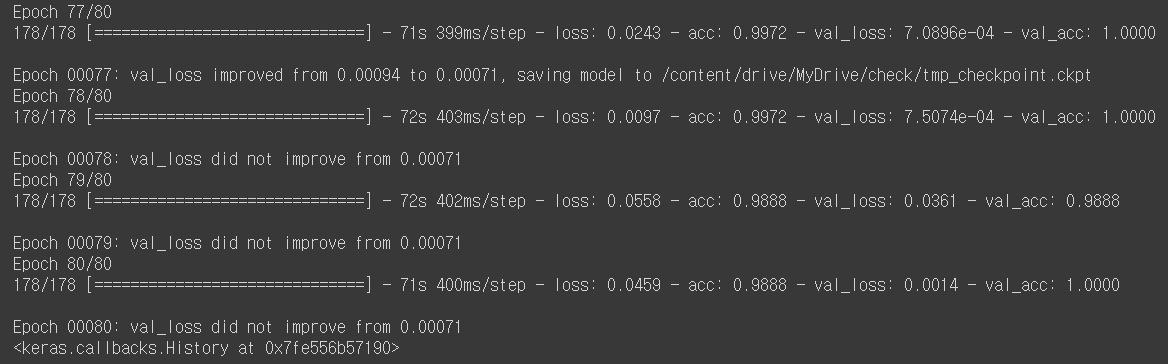

In [32]:
model.fit(
	train_video_generator
	,batch_size = 3
	,epochs = 80
	,validation_data=(X_val, y_val)
	,callbacks=[checkpoint]
	,verbose=1
	)

Epoch 1/80
178/178 [==============================] - 400s 2s/step - loss: 1.5758 - acc: 0.3876 - val_loss: 0.9068 - val_acc: 0.6292

Epoch 00001: val_loss improved from inf to 0.90685, saving model to /content/drive/MyDrive/check/tmp_checkpoint.ckpt
Epoch 2/80
178/178 [==============================] - 72s 403ms/step - loss: 1.1087 - acc: 0.4635 - val_loss: 0.7386 - val_acc: 0.8652

Epoch 00002: val_loss improved from 0.90685 to 0.73863, saving model to /content/drive/MyDrive/check/tmp_checkpoint.ckpt
Epoch 3/80
178/178 [==============================] - 72s 405ms/step - loss: 1.0912 - acc: 0.4579 - val_loss: 0.6705 - val_acc: 0.7528

Epoch 00003: val_loss improved from 0.73863 to 0.67049, saving model to /content/drive/MyDrive/check/tmp_checkpoint.ckpt
Epoch 4/80
178/178 [==============================] - 72s 403ms/step - loss: 0.9207 - acc: 0.5983 - val_loss: 0.4665 - val_acc: 0.9551

Epoch 00004: val_loss improved from 0.67049 to 0.46649, saving model to /content/drive/MyDrive/chec

In [33]:
model.load_weights(checkpoint_path)

In [34]:
# 모델 저장
model.save("/content/drive/MyDrive/model/MobileNet+GRU.h5")

# test

In [35]:
X_test = np.load('/content/drive/MyDrive/data/X_test_wide(5).npy')
y_test = np.load('/content/drive/MyDrive/data/y_test_wide(5).npy')

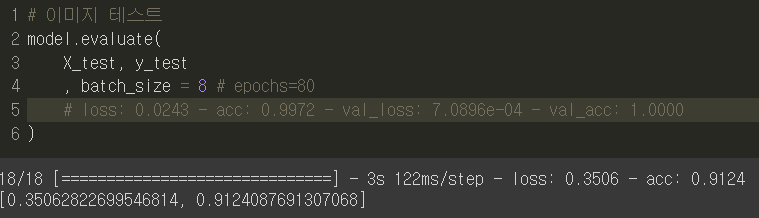

In [36]:
# 이미지 테스트
model.evaluate(
    X_test, y_test
    , batch_size = 8 # epochs=80
    # loss: 0.0243 - acc: 0.9972 - val_loss: 7.0896e-04 - val_acc: 1.0000
)

18/18 [==============================] - 3s 122ms/step - loss: 0.3506 - acc: 0.9124


[0.35062822699546814, 0.9124087691307068]